# SI 618 Homework #7
## Kaggle Competition- Spaceship Titanic

In this competition we aim to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision.
* Target Variable: `Transported`

In [437]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from prettytable import PrettyTable
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline

### Data Loading

#### Exploring Train Data

##### Training data observations:
* The training set contains 8693 rows and 14 features.

In [438]:
df_train = pd.read_csv('spaceship-titanic/train.csv')
df_test = pd.read_csv('spaceship-titanic/test.csv')

df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [439]:
df_train.shape

(8693, 14)

In [440]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


##### Check for missing values:
* There are missing values in every variables, with `CryoSleep` contains the highest number of 217 null values. Despite this, the missing values for each feature represent a relatively small fraction of the dataset, with none exceeding 3% of the total number of observations.

In [441]:
train_null = df_train.isnull().sum()
train_null_df = pd.DataFrame({'Number': train_null,
                          'Proportion': train_null.values/len(df_train)})

train_null_df

,Number,Proportion
PassengerId,0,0.000000
HomePlanet,201,0.023122
CryoSleep,217,0.024963
Cabin,199,0.022892
Destination,182,0.020936
Age,179,0.020591
VIP,203,0.023352
RoomService,181,0.020821
FoodCourt,183,0.021051
ShoppingMall,208,0.023927


<Axes: >

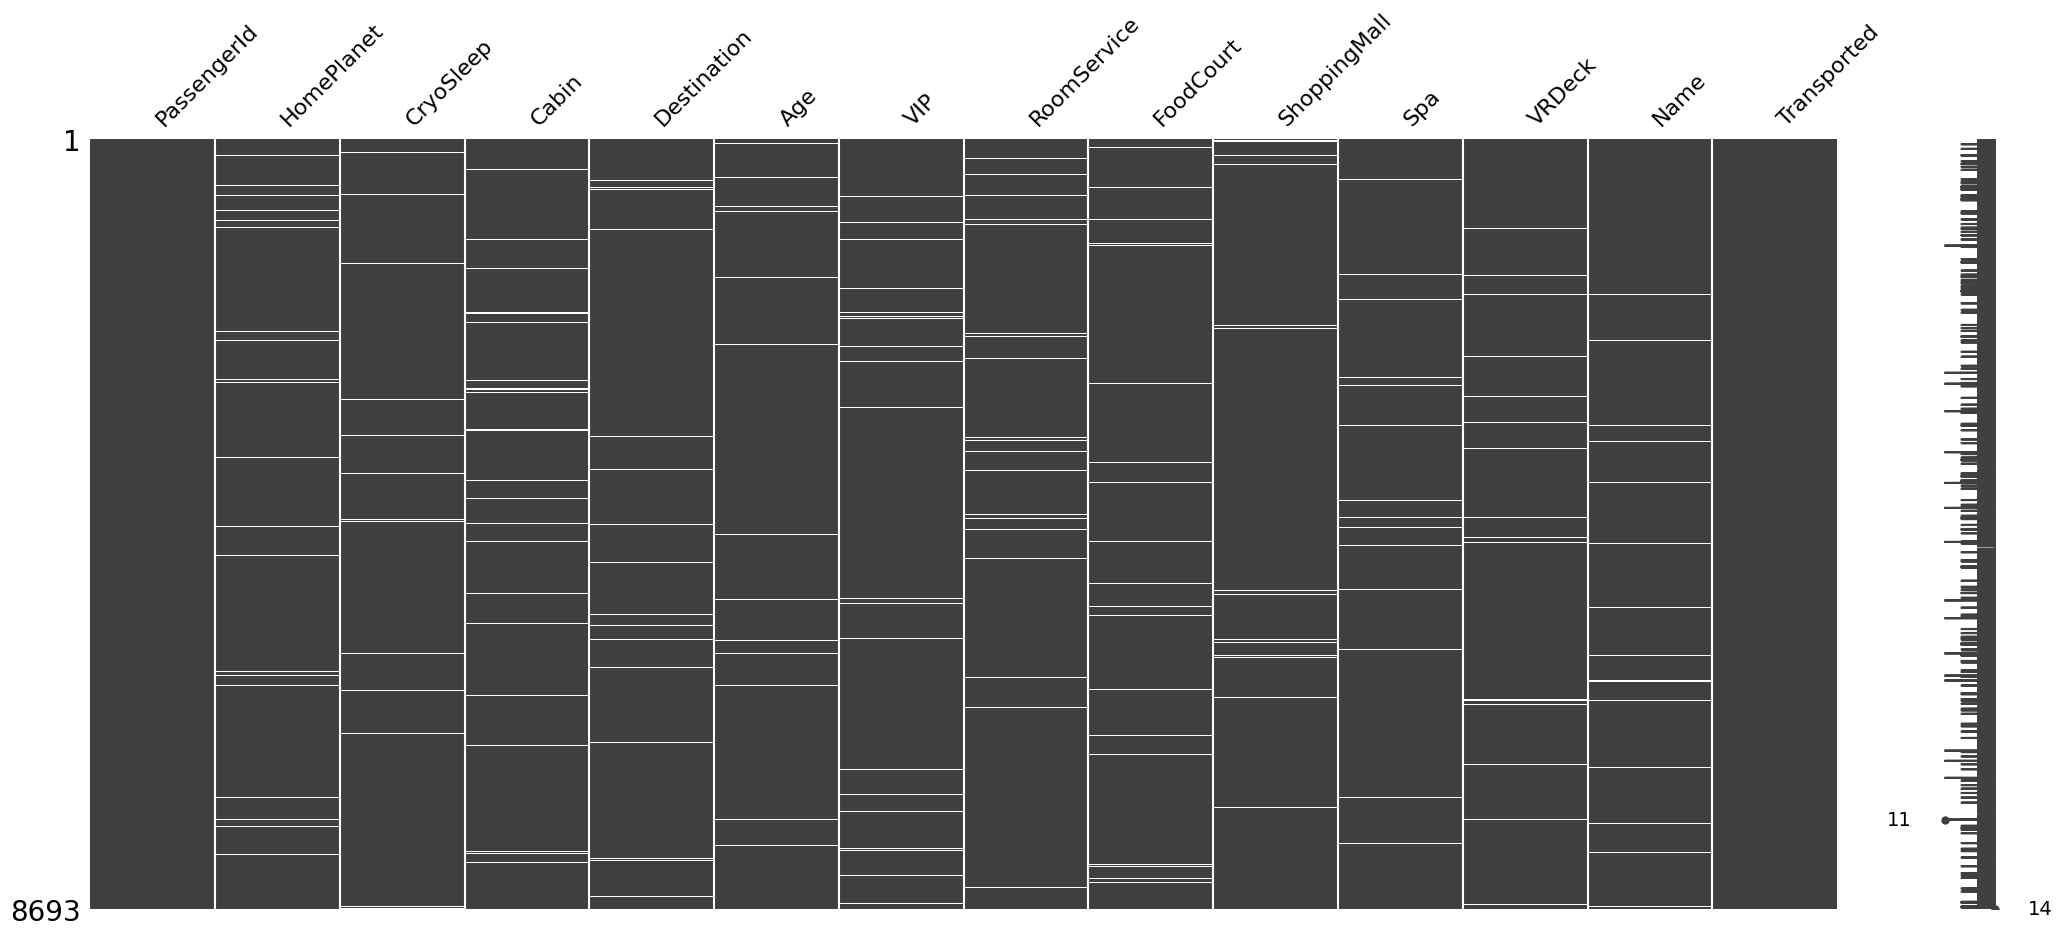

In [442]:
msno.matrix(df_train)

#### Exploring Test Data

##### Test data observations:
* The test set contains 4277 rows and 13 features.

In [443]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [444]:
df_test.shape

(4277, 13)

In [445]:
df_test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


##### Check for missing values:
* There are again, missing values in every variables, with `FoodCourt` contains the highest number of 106 null values. Despite this, the missing values for each feature represent a relatively small fraction of the dataset, with none exceeding 3% of the total number of observations.

In [446]:
test_null = df_test.isnull().sum()
test_null_df = pd.DataFrame({'Number': test_null,
                          'Proportion':test_null.values/len(df_test)})

test_null_df

,Number,Proportion
PassengerId,0,0.000000
HomePlanet,87,0.020341
CryoSleep,93,0.021744
Cabin,100,0.023381
Destination,92,0.021510
Age,91,0.021277
VIP,93,0.021744
RoomService,82,0.019172
FoodCourt,106,0.024784
ShoppingMall,98,0.022913


<Axes: >

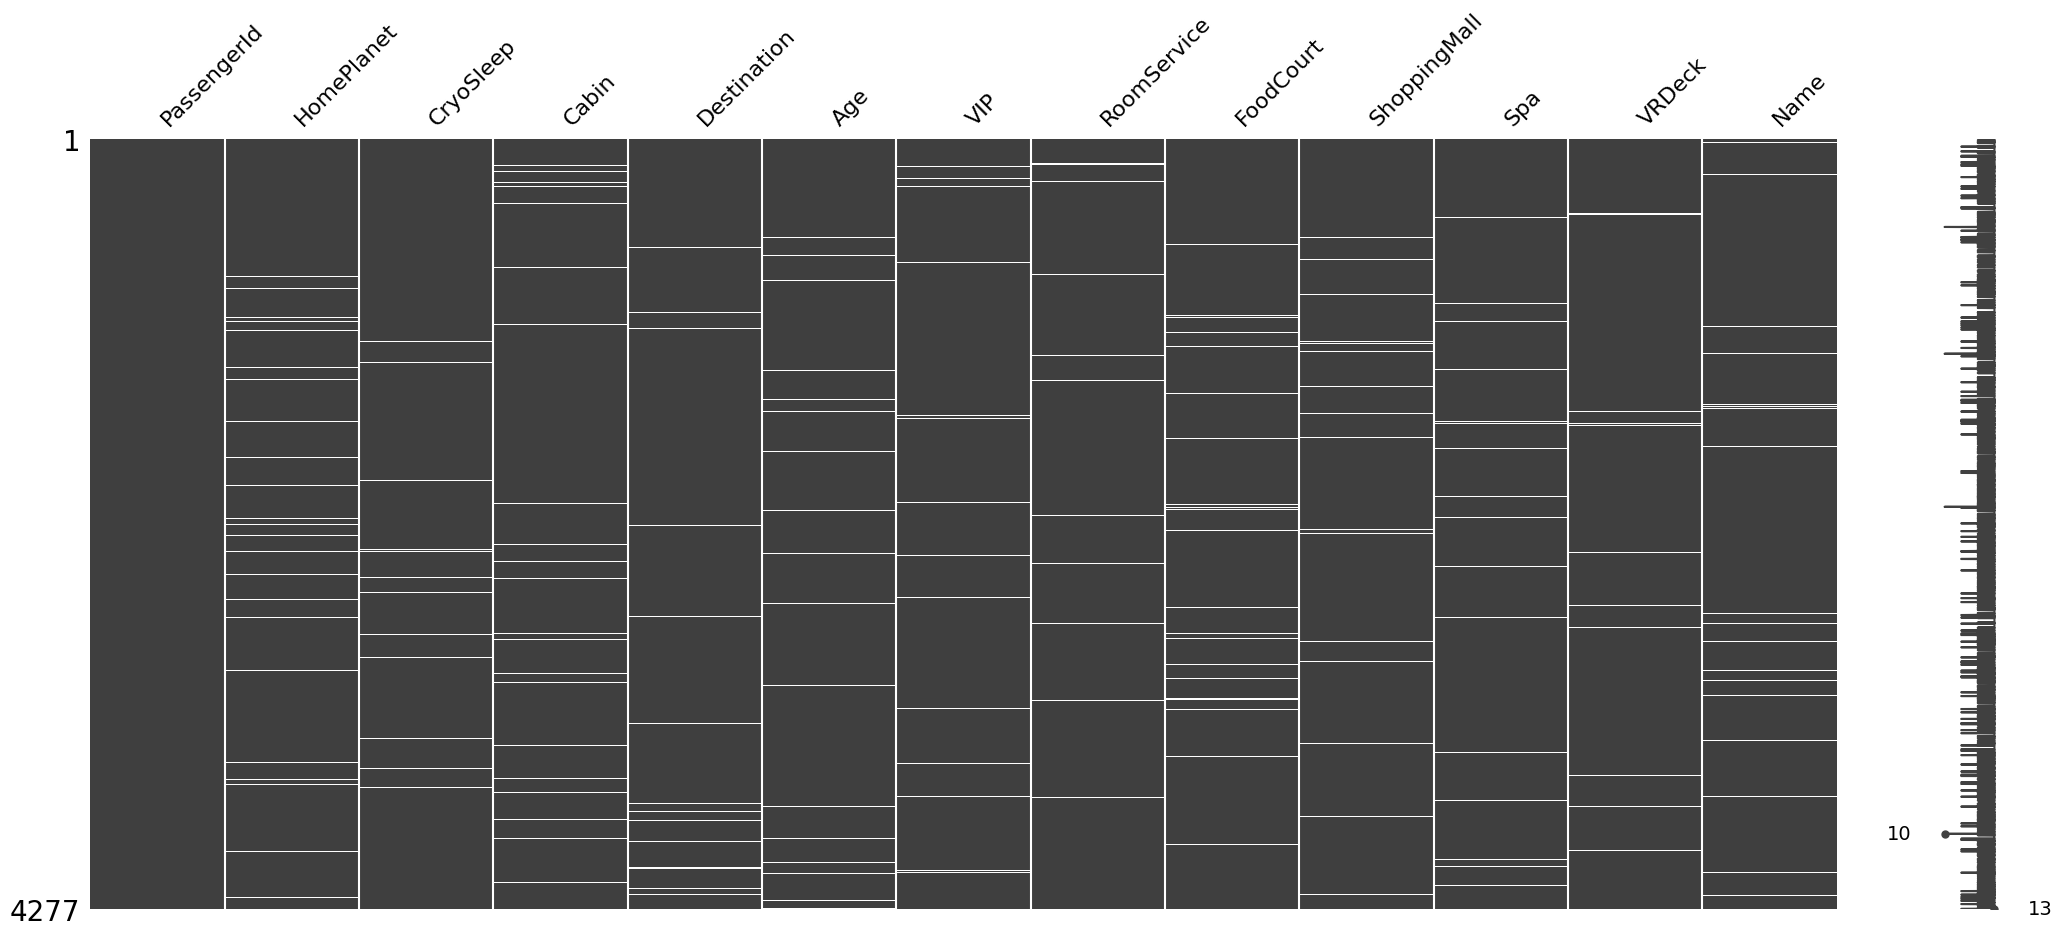

In [447]:
msno.matrix(df_test)

---

### Exploratory Data Analysis (EDA)

##### Target: `Transported`

We have about same proportion of people who got transported and not. So, the data is balanced and accuary is a good metric to choose while we build the models.

/var/folders/ds/2gb2x6p93mvcg0033697ys2c0000gn/T/ipykernel_21790/1414420216.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train['Transported'], palette=['skyblue', 'pink'])


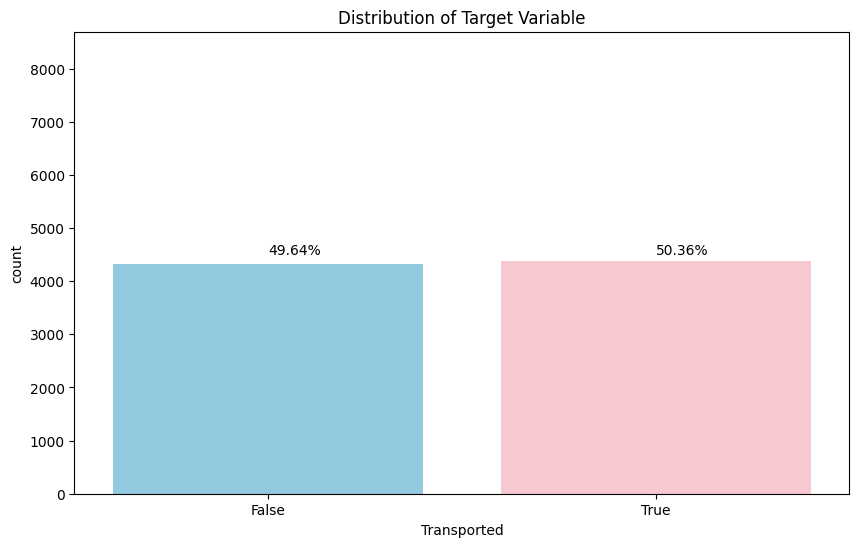

In [448]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df_train['Transported'], palette=['skyblue', 'pink'])
plt.ylim(0,len(df_train))
plt.title('Distribution of Target Variable')
plt.annotate('49.64%',(0,4500))
plt.annotate('50.36%',(1,4500))
plt.show()

##### Numerical Features
From the distributions of the continuous features, we can clearly see that they are right skewed and might have to transform the values for model training.

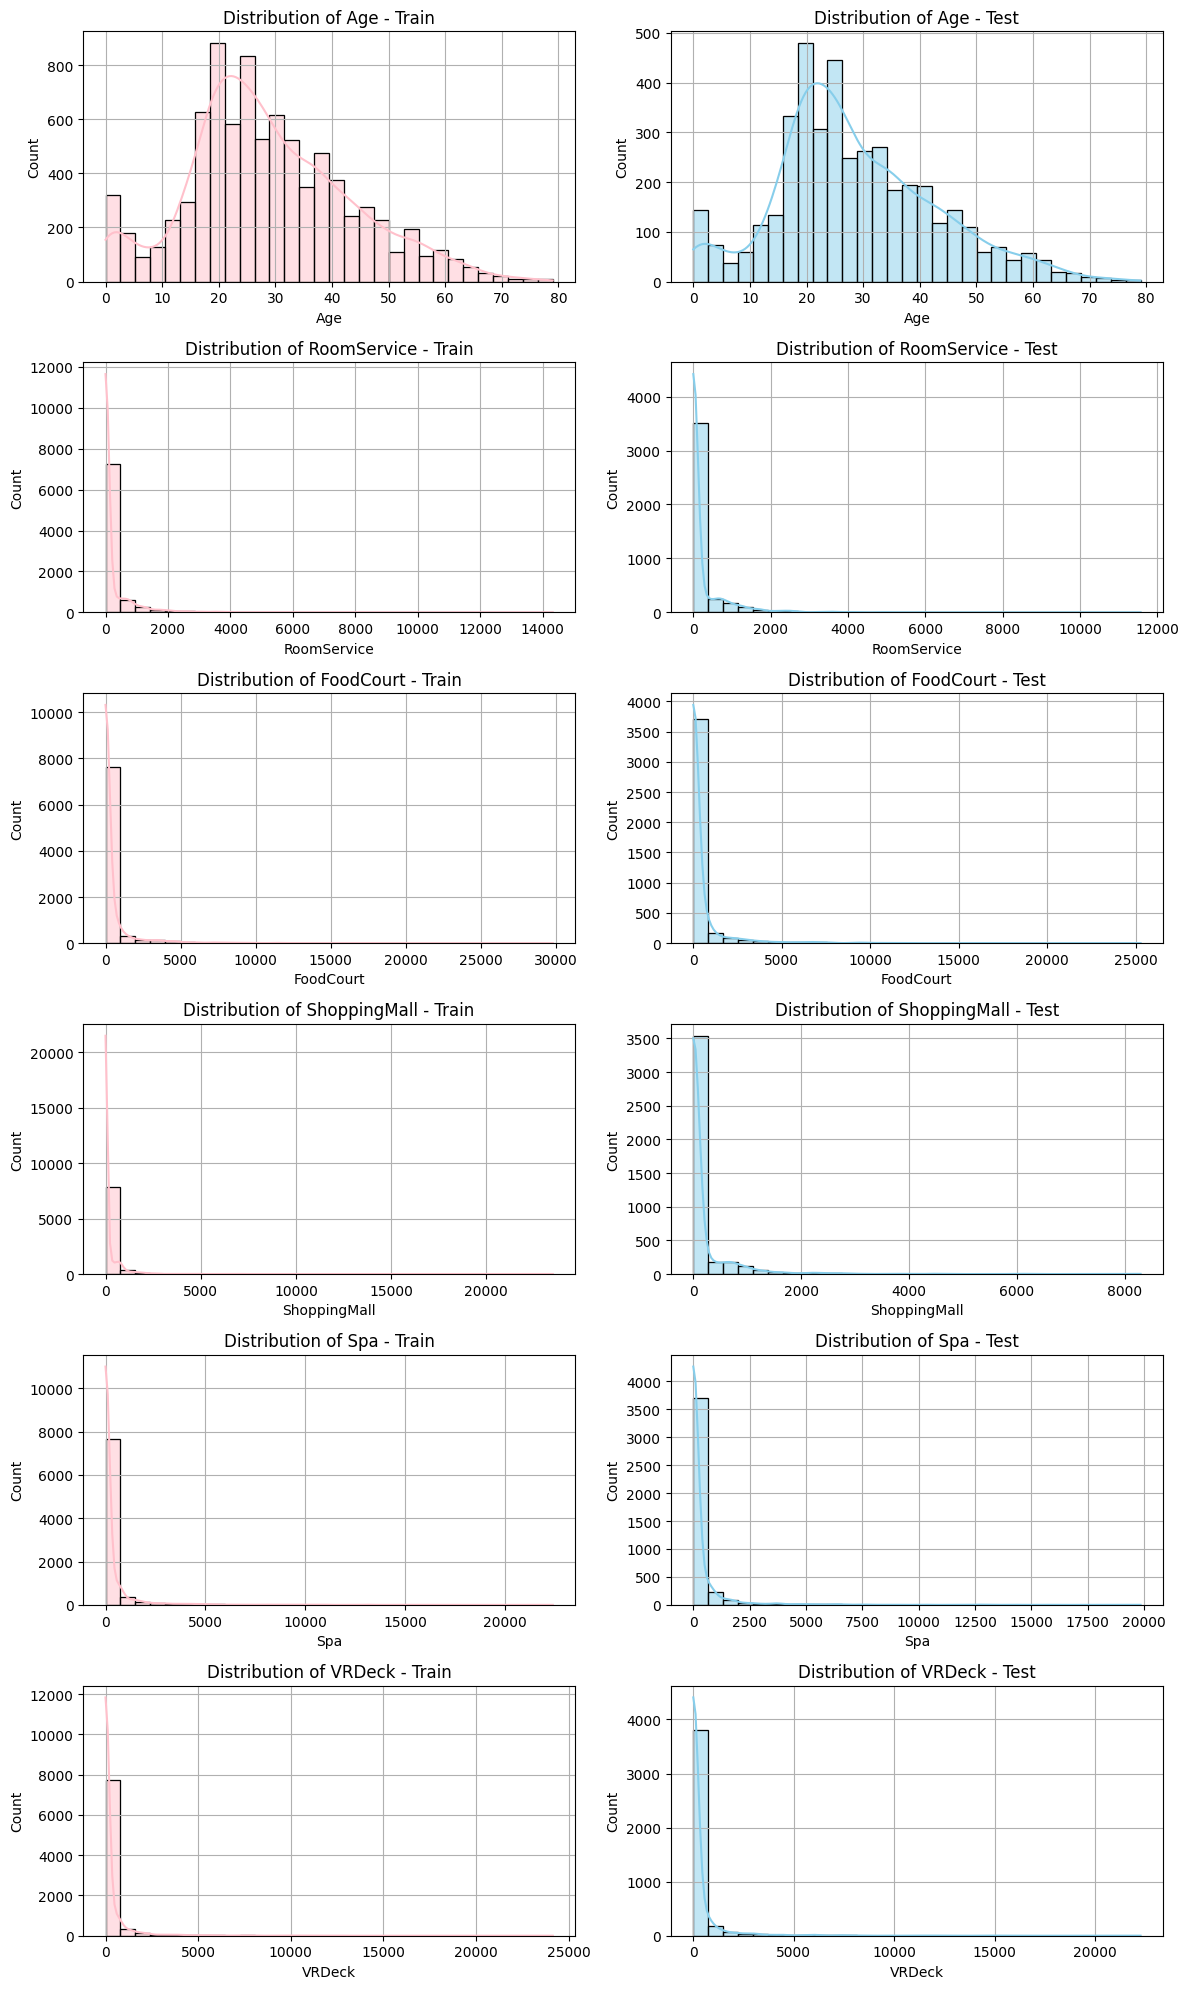

In [449]:
numerical_col = df_train.select_dtypes(include=['float64']).columns.tolist()

fig, ax = plt.subplots(6, 2, figsize=(12, 20))

for i in range(6):
    sns.histplot(ax=ax[i, 0], data=df_train, x=numerical_col[i], kde=True,
                  color='pink', bins = 30, alpha=0.5)
    ax[i, 0].set_title(f'Distribution of {numerical_col[i]} - Train')
    ax[i, 0].grid()

for i in range(6):
    sns.histplot(ax=ax[i, 1], data=df_test, x=numerical_col[i],
                  kde=True, color='skyblue', bins = 30, alpha=0.5)
    ax[i, 1].set_title(f'Distribution of {numerical_col[i]} - Test')
    ax[i, 1].grid()

plt.tight_layout()
plt.show()

##### Numerical Values v.s Target `Transported`
To observe whether people are transported or not will have a relationship with the numerical value, **boxplots** are drawn to show the relationships. Also, by the boxplots we can discover that there are outliers in each feature, thus transforming the data before fitting the models might give us a better result.

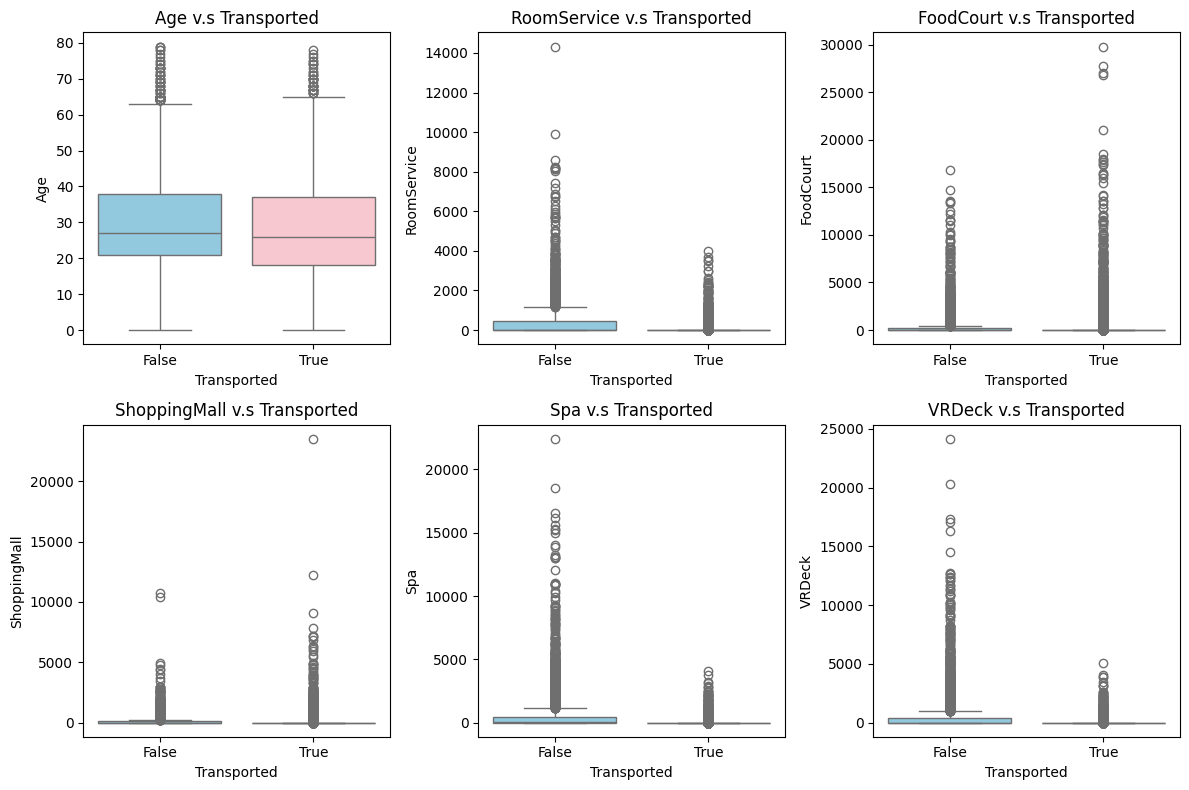

In [450]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for i, col in enumerate(numerical_col):
    sns.boxplot(ax=ax[i//3, i%3], data=df_train, x='Transported', hue='Transported',
                 y=col, palette=['skyblue', 'pink'])
    ax[i//3, i%3].set_title(f'{col} v.s Transported')
    ax[i//3, i%3].legend([],[], frameon=False)

plt.tight_layout()
plt.show()    

##### Pairplot for Bivariate Analysis
Through the pairplot, we can discover that:
* The plot of `Spa` vs `VRDeck` has a good seperation between the classes. People who had spent less money on these were most likely to be transported. 
* The plot of `Spa` vs `RoomService` also has a good seperation between the classes. People who had spent less money on these were most likely to be transported.
* `RoomService`, `Spa`, and `VRDeck` have a good differentiation between classes.

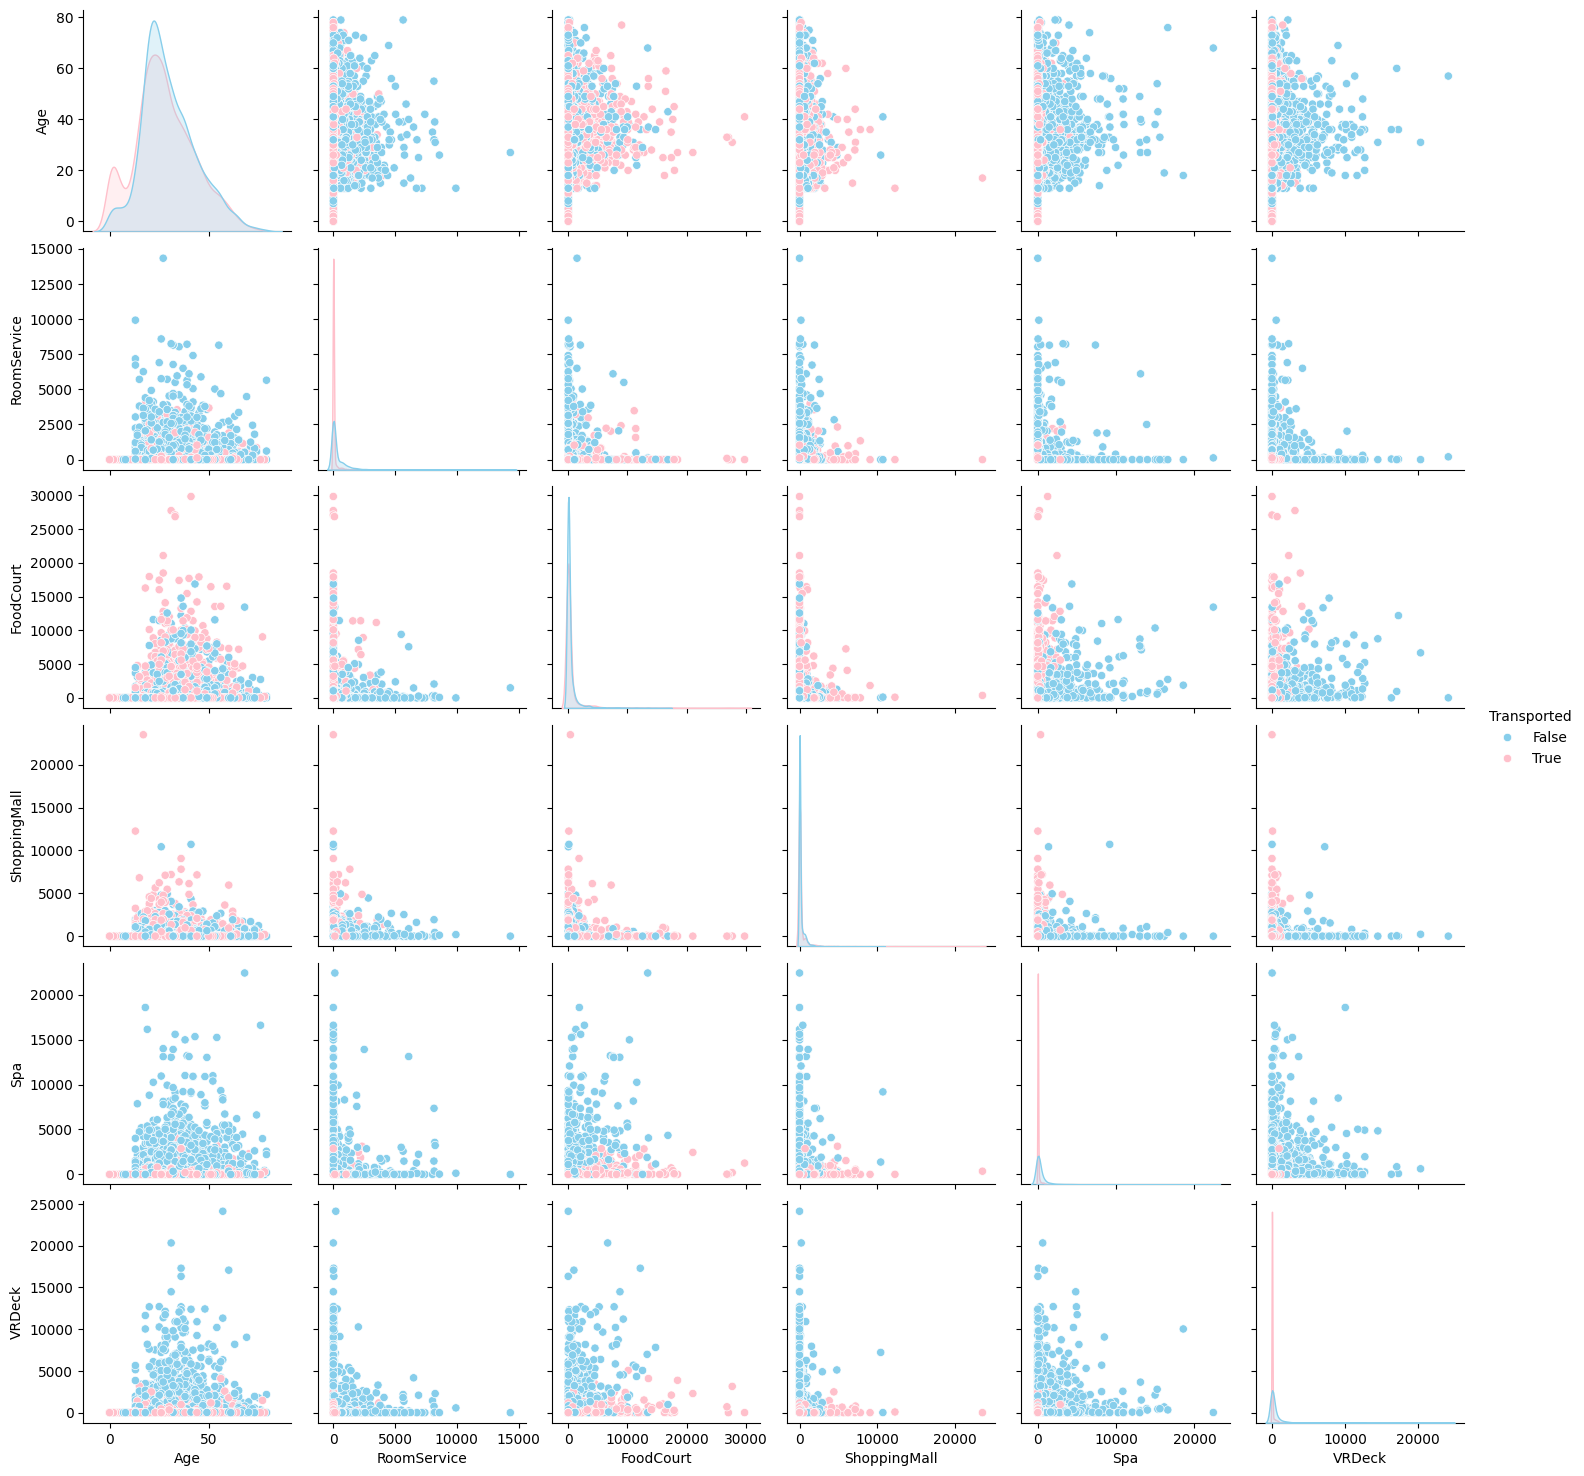

In [451]:
pair_df = pd.concat([df_train.select_dtypes(include=['float64', 'int64']),
                      df_train['Transported']], axis=1)

# Plot pairplot
sns.pairplot(pair_df, hue='Transported', palette=['skyblue', 'pink'],
              diag_kind='kde')

plt.show()

##### Categorical Values v.s Target `Transported`
* The number of people that are transported is less than people that are not transported.
* `CrypSleep` has good differentiation, people who have been put into suspended animation are more likely to be transported.

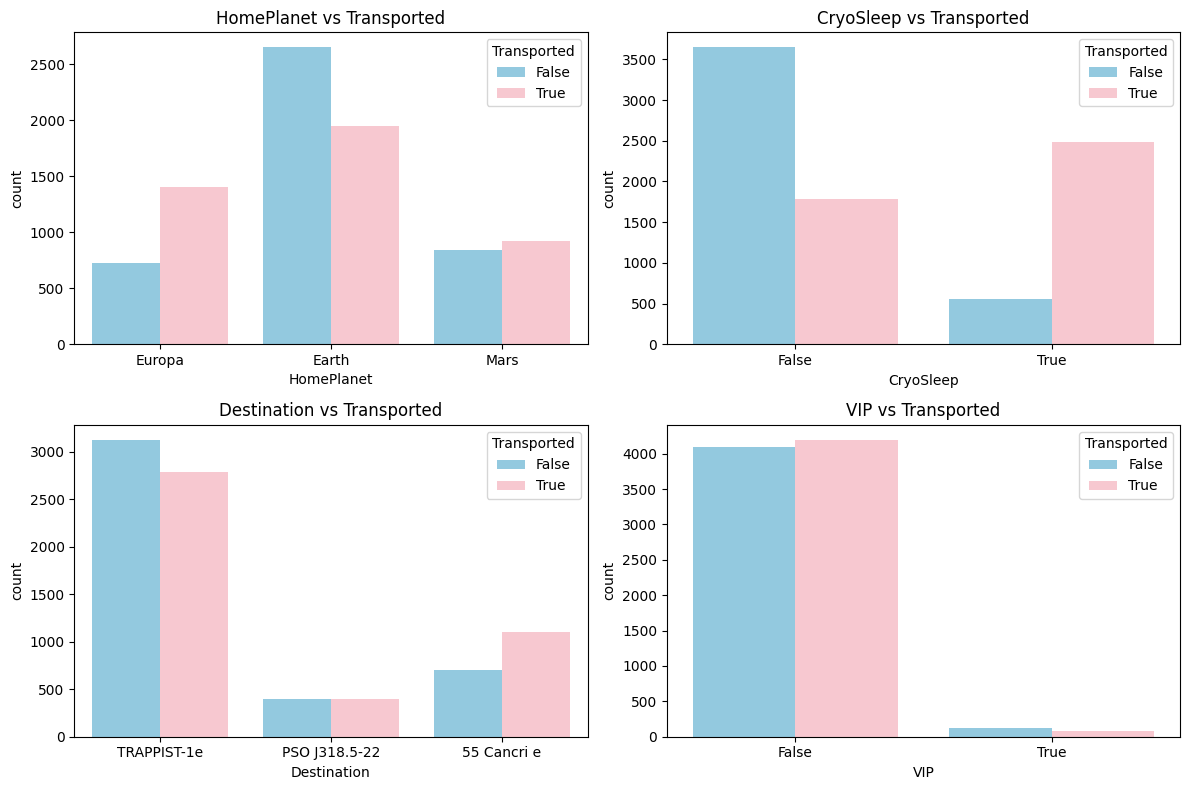

In [452]:
category_col = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(category_col):
    sns.countplot(ax=ax[i//2, i%2], x=category_col[i], hue='Transported',
               data=df_train, palette=['skyblue', 'pink'])
    ax[i//2, i%2].set_title(f'{category_col[i]} vs Transported')

plt.tight_layout()
plt.show()    

##### Correlation Plot
We cannot see any obvious correlation between variables, the highest correlation of all numerical features is `FoodCourt` vs `VRDeck` with a value of 0.23.

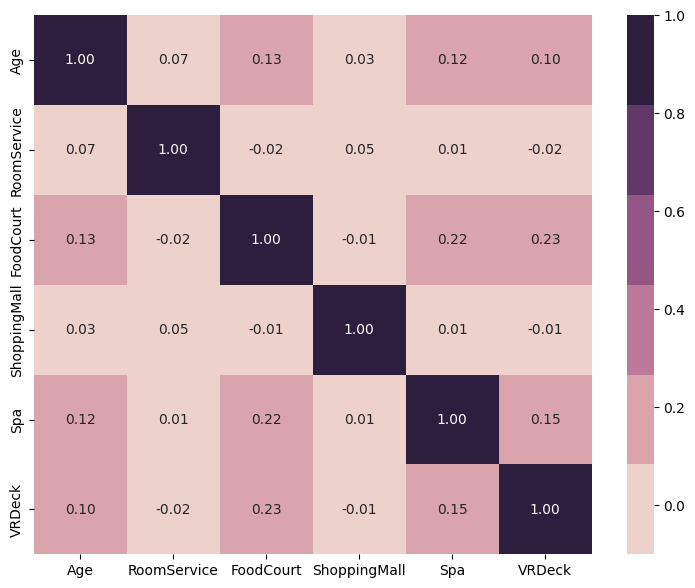

In [453]:
correlation_matrix = df_train[numerical_col].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap=sns.cubehelix_palette(), fmt=".2f",vmax=1,vmin=-0.1)
plt.show()

#### Statistical Inference

##### Two Sample T-Test
To determine whether the means of two groups are significantly different from each other, we will perform the t-test and set
$$H_0: \mu_{true} = \mu_{false}$$
$$H_1: \mu_{true} \neq \mu_{false}$$

and $\alpha = 0.05$.


From the result table below, we discover that under $\alpha = 0.05$, all features except `ShoppingMall` have p-value less than 0.05, indicating that we will rehect $H_0$ and conclude that there are significant differences between *True* and *False* groups.


In [454]:
# Perform t-test
def t_test(data, numerical_col):
    ttest_results = {}
    table = PrettyTable()
    table.field_names = ['Feature', 'T_Stat', 'P_Value']

    for col in numerical_col:
        group_True = data[data['Transported'] == True][col]
        group_False = data[data['Transported'] == False][col]

        t_stat, p_value = stats.ttest_ind(group_True, group_False, nan_policy='omit')
        table.add_row([col, t_stat, p_value])
    
    return print(table)


t_test(df_train, numerical_col)

+--------------+---------------------+------------------------+
|   Feature    |        T_Stat       |        P_Value         |
+--------------+---------------------+------------------------+
|     Age      |  -6.941461666045089 | 4.165050977554494e-12  |
| RoomService  |  -23.27230572812196 | 3.400493892669515e-116 |
|  FoodCourt   |  4.299893771259008  | 1.7278653407296636e-05 |
| ShoppingMall |  0.934056481671101  |   0.3503013444989256   |
|     Spa      | -20.914657362229097 | 9.275825095363414e-95  |
|    VRDeck    | -19.517825470012635 | 4.9897017399892476e-83 |
+--------------+---------------------+------------------------+


---

### Data Preprocessing

We will first drop the `Name` column since it might not be effective for our analysis.

In [455]:
# Drop column 'name'
df_train = df_train.drop('Name', axis=1)
df_test = df_test.drop('Name', axis=1)

#### Handle `Cabin` Column
Since we know that `Cabin` takes the form `deck/num/side`, we will want to consider them separately. However, since the cabin number is the number of the room, which might not be important for the response, we will not consider it and create a new column `Cabin_Side` which contains the deck and the side of the cabin.

* Reference: [Spaceship: Best Random Forest Solution Score 0.8](https://www.kaggle.com/code/madmax2003/spaceship-best-random-forest-solution-score-0-8)


In [456]:
# Define the cabin transformation function
def cabin_comb(x):
    if pd.notnull(x) and x != '':
        return x[0]+x[-1]

# Transform the feature for both train and test data  
df_train['Cabin_Side'] = df_train['Cabin'].apply(cabin_comb)
df_test['Cabin_Side'] = df_test['Cabin'].apply(cabin_comb)

# Drop the `Cabin` column
df_train = df_train.drop('Cabin', axis=1)
df_test = df_test.drop('Cabin', axis=1)

Text(0.5, 1.0, 'Transported Proportion by Cabin_Side')

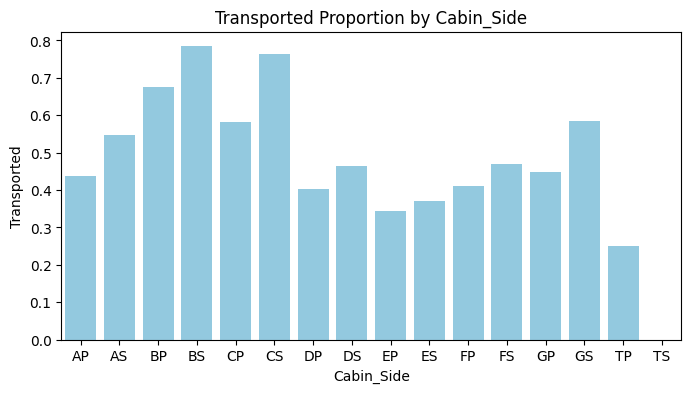

In [457]:
cabin_trans = (df_train.groupby('Cabin_Side')['Transported'].sum())/\
    (df_train.groupby('Cabin_Side')['Transported'].count())

cabin_trans = pd.DataFrame(cabin_trans).reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(data = cabin_trans,
            x = 'Cabin_Side',
            y = 'Transported', color='skyblue')
plt.title('Transported Proportion by Cabin_Side')


By the transported proportion plot below, we can see that passengers on `A`, `B`, and `C` cabins are likely to be transported. Also, except for cabin `T`, all the other cabins that are on the Starboard size (`S`) tend to be transported than those on the port side(`P`). Which means that `Cabin_Side` is an important feature.

#### Handle missing values
* For categorical features, we will fill the missing value with *mode* value.
* For continuous feature, we will fill the missing value with *mean* value since median value are all 0 for continuous variables.

In [458]:
df_train['CryoSleep'].value_counts()

CryoSleep
False    5439
True     3037
Name: count, dtype: int64

In [459]:
def fill_missing(data, categorical_col, continuous_col):
    for col in categorical_col:
        mode_value = data[col].mode().tolist()[0]
        data[col].fillna(mode_value, inplace=True)
    
    for con in continuous_col:
        median_value = data[con].mean()
        data[con].fillna(median_value, inplace=True)


# Define categorical features
categorical_col = df_train.select_dtypes(include=['object']).columns.tolist()[1:]
# Define for continuous features
continuous_col = df_train.select_dtypes(include=['float64']).columns.tolist()

# Fill NA for train set
fill_missing(df_train, categorical_col, continuous_col)
# Fill NA for test set
fill_missing(df_test, categorical_col, continuous_col)

/Users/annie/@umich/SI618/SI_618_WN_24_Files/.venv/lib/python3.10/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(
/Users/annie/@umich/SI618/SI_618_WN_24_Files/.venv/lib/python3.10/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


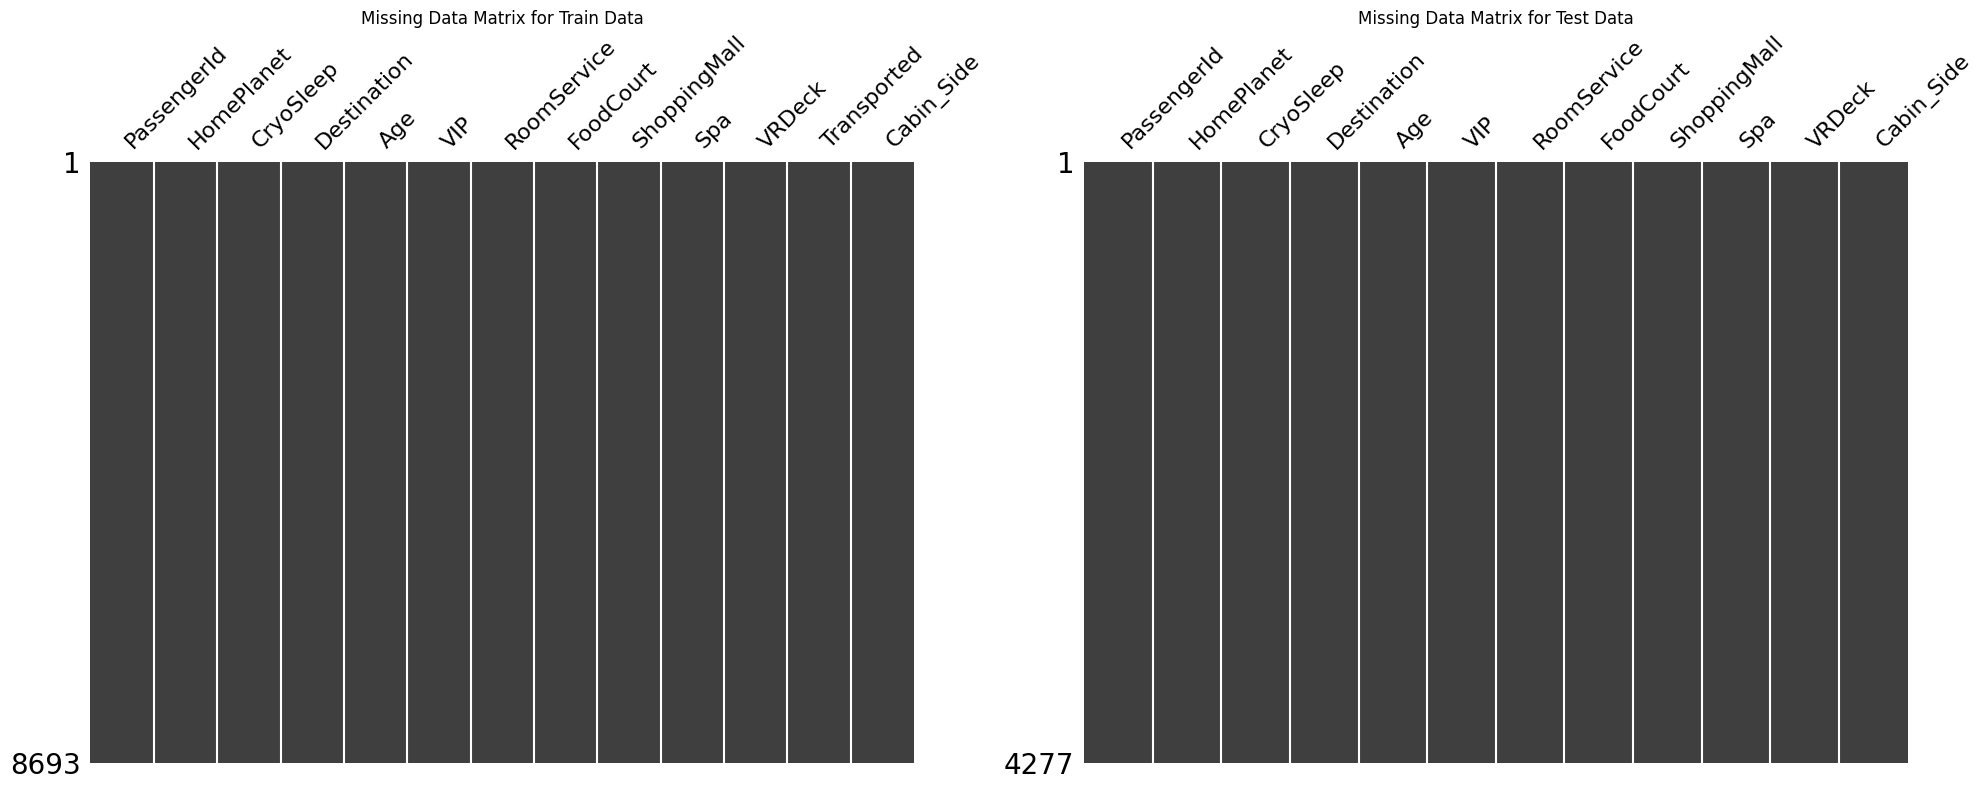

In [422]:
# Visualize missing data
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
msno.matrix(df_train, ax=ax[0])
msno.matrix(df_test, ax=ax[1])

ax[0].set_title('Missing Data Matrix for Train Data')
ax[1].set_title('Missing Data Matrix for Test Data')

plt.tight_layout()
plt.show()

#### One-Hot Encoding/ Binary Data Transformation

For train set:

In [460]:
# Transform binary data
y_train = df_train['Transported'].apply(lambda x: 0 if x is False else 1).astype(int)
df_train = df_train.drop('Transported', axis=1)

df_train['CryoSleep'] = df_train['CryoSleep'].apply(lambda x: 0 if x is False else 1).astype(int)
df_train['VIP'] = df_train['VIP'].apply(lambda x: 0 if x is False else 1).astype(int)

# Define the encoded column
categorical_col_dummy = ['HomePlanet', 'Destination', 'Cabin_Side']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False) 

# Transform the data
encoded_data = encoder.fit_transform(df_train[categorical_col_dummy])

# Convert the data back to a dataframe
df_train_encoded = pd.DataFrame(
    encoded_data, 
    columns=encoder.get_feature_names_out()
)

# Combine the train dataset with the encoded dataset
continuous_col = df_train.select_dtypes(include=['float64']).columns.tolist()
add_col = ['PassengerId'] + continuous_col[:] + ['CryoSleep', 'VIP']
df_train_encoded = pd.concat([df_train[add_col], df_train_encoded], axis=1)
df_train_encoded

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep,VIP,HomePlanet_Earth,...,Cabin_Side_DP,Cabin_Side_DS,Cabin_Side_EP,Cabin_Side_ES,Cabin_Side_FP,Cabin_Side_FS,Cabin_Side_GP,Cabin_Side_GS,Cabin_Side_TP,Cabin_Side_TS
0,0001_01,39.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,24.0,109.0,9.0,25.0,549.0,44.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0004_01,16.0,303.0,70.0,151.0,565.0,2.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8689,9278_01,18.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8690,9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8691,9280_01,32.0,0.0,1049.0,0.0,353.0,3235.0,0,0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


For test set:

In [461]:
# Transform binary data
df_test['CryoSleep'] = df_test['CryoSleep'].apply(lambda x: 0 if x is False else 1).astype(int)
df_test['VIP'] = df_test['VIP'].apply(lambda x: 0 if x is False else 1).astype(int)

# Define the encoded column
categorical_col_dummy = ['HomePlanet', 'Destination', 'Cabin_Side']

# Transform the data
encoded_data = encoder.fit_transform(df_test[categorical_col_dummy])

# Convert the data back to a dataframe
df_test_encoded = pd.DataFrame(
    encoded_data, 
    columns=encoder.get_feature_names_out()
)

# Combine the train dataset with the encoded dataset
continuous_col = df_test.select_dtypes(include=['float64']).columns.tolist()
add_col = ['PassengerId'] + continuous_col[:] + ['CryoSleep', 'VIP']
df_test_encoded = pd.concat([df_test[add_col], df_test_encoded], axis=1)
df_test_encoded

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CryoSleep,VIP,HomePlanet_Earth,...,Cabin_Side_DP,Cabin_Side_DS,Cabin_Side_EP,Cabin_Side_ES,Cabin_Side_FP,Cabin_Side_FS,Cabin_Side_GP,Cabin_Side_GS,Cabin_Side_TP,Cabin_Side_TS
0,0013_01,27.000000,0.0,0.0,0.0,0.0,0.0,1,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0018_01,19.000000,0.0,9.0,0.0,2823.0,0.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0019_01,31.000000,0.0,0.0,0.0,0.0,0.0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0021_01,38.000000,0.0,6652.0,0.0,181.0,585.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0023_01,20.000000,10.0,0.0,635.0,0.0,0.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,34.000000,0.0,0.0,0.0,0.0,0.0,1,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4273,9269_01,42.000000,0.0,847.0,17.0,10.0,144.0,0,0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4274,9271_01,28.658146,0.0,0.0,0.0,0.0,0.0,1,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4275,9273_01,28.658146,0.0,2680.0,0.0,0.0,523.0,0,0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

### Modeling

In [462]:
# Define X and y (y is defined above)
X_train = df_train_encoded.drop(['PassengerId'], axis=1)
X_test = df_test_encoded.drop('PassengerId', axis=1)

# Expenditure
X_train_exp = df_train_encoded.drop(['PassengerId','RoomService', 'Spa', 'VRDeck' ], axis=1)
#X_test = df_test_encoded.drop('PassengerId', axis=1)
X_train_exp

,Age,FoodCourt,ShoppingMall,CryoSleep,VIP,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,...,Cabin_Side_DP,Cabin_Side_DS,Cabin_Side_EP,Cabin_Side_ES,Cabin_Side_FP,Cabin_Side_FS,Cabin_Side_GP,Cabin_Side_GS,Cabin_Side_TP,Cabin_Side_TS
0,39.0,0.0,0.0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24.0,9.0,25.0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,58.0,3576.0,0.0,0,1,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33.0,1283.0,371.0,0,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,70.0,151.0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,6819.0,0.0,0,1,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8689,18.0,0.0,0.0,1,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8690,26.0,0.0,1872.0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8691,32.0,1049.0,0.0,0,0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Logistic Regression

Model|Model Type|Training Accuracy
-|-|-
lr_1|Original Data|0.7897
lr_2|StandardScaler|0.7897
lr_3|MinMaxScaler|0.7899

By trying three types of scaler, we find out that MinMaxScaler has the highest train accuracy, with best parameters as follow.

**Best Parameters:**
* 'C': 7.0
* 'penalty': 'l1'
* 'solver': 'saga'


In [ ]:
# Logistic Regression Model
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('logisticregression', LogisticRegression(max_iter=5000, random_state=42))
])

lr_grid = [
    {'logisticregression__solver': ['liblinear', 'saga'], 
     'logisticregression__penalty': ['l1', 'l2'],
       'logisticregression__C': [7.0, 7.25, 7.5, 7.75]},
    {'logisticregression__solver': ['newton-cg', 'lbfgs', 'sag'],
      'logisticregression__penalty': ['l2', 'none'],
        'logisticregression__C': [1.0, 10.0]},
    {'logisticregression__solver': ['saga'],
      'logisticregression__penalty': ['elasticnet'],
        'logisticregression__C': [1.0, 10.0],
          'logisticregression__l1_ratio': [0, 0.5, 1]}
]

lr_search = GridSearchCV(lr_pipe, lr_grid, cv=5, verbose=1, scoring='accuracy')
lr_search.fit(X_train, y_train)

# Print the best model parameters
print("Best LR Parameters:", lr_search.best_params_)
print("Best cross-validation score (accuracy): {:.4f}".format(lr_search.best_score_))


best_model = lr_search.best_estimator_
# y_pred = best_model.predict(X_test)

---

#### Random Forest Classifier

Model|Model Type|Train Accuracy
-|-|-
RF_1|Original Data|0.8019
RF_2|StandardScaler|0.8020
RF_3|MinMaxScaler|0.8019

By trying three types of scaler, we find out that StandardScaler has the highest train accuracy, with best parameters as follow.

**Best RF Parameters:**
* 'bootstrap': True
* 'max_depth': None
* 'max_features': 'sqrt'
* 'min_samples_leaf': 4
* 'min_samples_split': 10
* 'n_estimators': 100

In [315]:
# Random Forest Model
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),  # Note: This step is optional for Random Forest
    ('rf', RandomForestClassifier(random_state=42))
])

rf_grid = {
    'rf__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'rf__max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'rf__max_features': ['sqrt', 'log2'],
    'rf__bootstrap': [True, False]  # Method for sampling data points
}

rf_search = GridSearchCV(rf_pipe, rf_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
rf_search.fit(X_train, y_train)
print("Best RF Parameters:", rf_search.best_params_)
print("Best cross-validation score (accuracy): {:.4f}".format(rf_search.best_score_))

best_model = rf_search.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best RF Parameters: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Best cross-validation score (accuracy): 0.8020


In [154]:
y_pred = best_model.predict(X_test)

In [155]:
submission = ['False' if i == 0 else 'True' for i in y_pred]

submission_rf = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Transported': submission
})

In [156]:
submission_rf.to_csv('submission_rf_minmaxscaled.csv', index=False)

---

#### Support Vector Machine Classifier

Model|Model Type|Training Accuracy
-|-|-
svc_1|StandardScaler|0.7968
svc_2|MinMaxScaler|0.7796

By trying three types of scaler, we find out that StandardScaler has the highest train accuracy, with best parameters as follow.

**Best SVC Parameters:**
* 'C': 1
* 'gamma': 0.01
* 'kernel': 'linear'

In [464]:
# SVM Classifier
svc_grid = {
    'svc__C': [1, 5, 10, 15],
    'svc__gamma': [0.01, 0.05, 0.1],
    'svc__kernel': ['linear', 'rbf', 'poly']
}

svc_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC(random_state=42))
])

svc_search = GridSearchCV(svc_pipe, svc_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
svc_search.fit(X_train, y_train)

# Print the best model parameters
print("Best SVM Parameters:", svc_search.best_params_)
print("Best cross-validation score (accuracy): {:.4f}".format(svc_search.best_score_))


best_model = svc_search.best_estimator_
# y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Best SVM Parameters: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'linear'}
Best cross-validation score (accuracy): 0.7968


---

#### XGBoost Classifier

Model|Model Type|Training Accuracy
-|-|-
XGB_1|Original Data|0.8039
XGB_2|StandardScaler| 0.8039
XGB_3|MinMaxScaler|0.8039

By trying three types of scaler, we will choose StandardScaler as the scaler of XGBoost, with best parameters as follow.

**Best XGB Parameters:**
* 'learning_rate': 0.01
* 'max_depth': 5
* 'n_estimators': 500


Reference: [XGBoost Python Package](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

In [465]:
# Adjusting the pipeline for a classification task
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Define the parameter grid to search (same as before, just ensure you're using classification-friendly parameters)
xgb_grid = {
    'xgb__n_estimators': [200, 300, 400, 500, 600],  # Example: searching over different values for n_estimators
    'xgb__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15],  # Example: searching over different values for learning_rate
    'xgb__max_depth': [1, 3, 5, 6] 
    }

# Initialize GridSearchCV for a classification task
xgb_search = GridSearchCV(pipeline, param_grid=xgb_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
xgb_search.fit(X_train, y_train)

print(f"Best parameters found: {xgb_search.best_params_}")
print(f"Best cross-validation score (accuracy): {xgb_search.best_score_}")

# Predict with test data
best_model = xgb_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 500}
Best cross-validation score (accuracy): 0.8038670823211624


In [166]:
submission = ['False' if i == 0 else 'True' for i in y_pred]

submission_xgb = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Transported': submission
})

submission_xgb.to_csv('submission_XGB_minmax.csv', index=False)

---

#### Gradient Boosting Classifier

Model|Model Type|Training Accuracy
-|-|-
GB_1|Original Data|0.8008
GB_2|StandardScaler| 0.8006
GB_3|MinMaxScaler|0.8009

By trying three types of scaler, we will choose MinMaxScaler as the scaler of Gradient Boosting Classifier, with best parameters as follow.

**Best GB Parameters:**
* 'learning_rate': 0.1
* 'n_estimators': 300

Reference: [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [467]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('gb', GradientBoostingClassifier(random_state=42))
])

gb_grid = {
    'gb__n_estimators': [50, 100, 150, 200, 300],
    'gb__learning_rate': [0.01, 0.1, 0.15, 0.2, 0.5]
}

gb_search = GridSearchCV(pipeline, param_grid=gb_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model
gb_search.fit(X_train, y_train)

# Display the best parameters and score
print(f"Best parameters found: {gb_search.best_params_}")
print(f"Best cross-validation score (accuracy): {gb_search.best_score_:.4f}")

# Predict with test data
best_model = gb_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters found: {'gb__learning_rate': 0.1, 'gb__n_estimators': 300}
Best cross-validation score (accuracy): 0.8006


In [468]:
# Save submission into csv file
submission = ['False' if i == 0 else 'True' for i in y_pred]

submission_gb = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Transported': submission
})

submission_gb.to_csv('submission_GB_scaled_v2.csv', index=False)

---

#### VotingClassifier

In the VotingClassifier, we first set up pipelines for each model, and then put them into the classifier. The soft voting method is in the model.

**Model 1**
* Models: Logistic Regression, Gradient Boosting Classifier, XGBoost Classifier, SVC, and Random Forest Classifier.
* Train Accuracy: 0.8228

**Model 2**
* Models: Gradient Boosting Classifier, XGBoost Classifier, SVC, and Random Forest Classifier.
* Train Accuracy: 0.8319
* Test Accuracy: 0.8034

**Model 3**
* Models:  Logistic Regression, Gradient Boosting Classifier, XGBoost Classifier, and Random Forest Classifier.
* Train Accuracy: 0.8320
* Test Accuracy: 0.8017

In [472]:
# Logistic Regression
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('lr', LogisticRegression(max_iter=5000, C=7.0, penalty='l1', 
                              solver='saga', random_state=42))
])

# Gradient Boosting Classifier pipeline
gb_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', GradientBoostingClassifier(learning_rate=0.1,
                                               n_estimators=300,
                                                 random_state=42))
])

# XGBoost Classifier pipeline
xgb_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(learning_rate=0.01, max_depth=5,
                                  n_estimators=500, use_label_encoder=False,
                                    eval_metric='logloss', random_state=42))
])

# SVC pipeline
svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(C=1, gamma=0.01, kernel='linear', probability=True))
])

# Random Forest Classifier pipeline
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(bootstrap=True, max_depth=None,
                                           max_features='sqrt',
                                           min_samples_leaf=4, 
                                           min_samples_split=10, 
                                           n_estimators=100))
])


In [475]:
voting_clf = VotingClassifier(
    estimators=[
        ('gb', gb_pipe),
        ('xgb', xgb_pipe),
        ('rf', rf_pipe),
        ('lr', lr_pipe)
        #('svc', svc_pipe)
    ],
    voting='soft' 
)

# Fit the Voting Classifier
voting_clf.fit(X_train, y_train)

# Calculate accuracy on the training data
y_train_pred = voting_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate on the test set
y_pred = voting_clf.predict(X_test)

Training Accuracy: 0.8320


In [476]:
submission = ['False' if i == 0 else 'True' for i in y_pred]

submission_voting = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Transported': submission
})

submission_voting.to_csv('submission_VotingClassifier_nosvc.csv', index=False)

---

#### Stacking Classifier

In the Stacking Classifier, we first set up pipelines for each model, and then put them into the classifier.

**Model 1**
* Models: Logistic Regression, Gradient Boosting Classifier, XGBoost Classifier, SVC, and Random Forest Classifier.
* Train Accuracy: 0.8310

**Model 2**
* Models: Gradient Boosting Classifier, XGBoost Classifier, SVC, and Random Forest Classifier.
* Train Accuracy: 0.8323
* Test Accuracy: 0.7996

**Model 3**
* Models:  Logistic Regression, Gradient Boosting Classifier, XGBoost Classifier, and Random Forest Classifier.
* Train Accuracy: 0.8289


Reference: [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [478]:
estimators=[
        ('gb', gb_pipe),
        ('xgb', xgb_pipe),
        ('rf', rf_pipe),
        ('lr', lr_pipe),
        ('svc', svc_pipe)
    ]


final_estimator = GradientBoostingClassifier(random_state=42)

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

stack_clf.fit(X_train, y_train)

# Calculate accuracy on the training data
y_train_pred = stack_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

y_pred = stack_clf.predict(X_test)


Training Accuracy: 0.8323


In [479]:
submission = ['False' if i == 0 else 'True' for i in y_pred]

submission_stacking = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Transported': submission
})

submission_stacking.to_csv('submission_StackingClassifier_nolr.csv', index=False)

### Best Kaggle Accuracy
The best accuracy for the competition is **0.8034** using **VotingClassifier** with Gradient Boosting Classifier, XGBoost Classifier, SVC, and Random Forest Classifier.
